# 2D Isostatic gravity inversion - Synthetic Model

Este [IPython Notebook](http://ipython.org/videos.html#the-ipython-notebook) utiliza a biblioteca de código aberto [Fatiando a Terra](http://fatiando.org/)

In [1]:
%matplotlib inline
import numpy as np
from scipy.misc import derivative
import scipy as spy
from scipy import interpolate
import matplotlib
#matplotlib.use('TkAgg', force=True)
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import math
import cPickle as pickle
import datetime
#from IPython.display import Image as img
#from IPython.display import Markdown as md
#from IPython.display import display as dp
import string as st

from scipy.misc import imread

from __future__ import division

from fatiando import gravmag, mesher, utils, gridder
from fatiando.mesher import Prism, Polygon
from fatiando.gravmag import prism
from fatiando.utils import ang2vec, si2nt, contaminate
from fatiando.gridder import regular, profile
from fatiando.vis import mpl

from numpy.testing import assert_almost_equal
from numpy.testing import assert_array_almost_equal
from pytest import raises

plt.rc('font', size=16)

/Users/macelabastos/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
import functions as fc

## Observation coordinates.

In [3]:
# Model`s limits
ymin = 0.0
ymax = 383000.0
zmin = -1000.0
#zmax = 45000.0
zmax = 40000.0
xmin = -100000.0
xmax = 100000.0

area = [ymin, ymax, zmax, zmin]

In [4]:
ny = 150 # number of observation datas and number of prisms along the profile
# coordinates defining the horizontal boundaries of the
# adjacent columns along the profile
y = np.linspace(ymin, ymax, ny)

In [5]:
# coordinates of the center of the columns forming the
# interpretation model
n = ny - 1
dy = (ymax - ymin)/n
ycmin = ymin + 0.5*dy
ycmax = ymax - 0.5*dy
yc = np.reshape(np.linspace(ycmin, ycmax, n),(n,1))
x = np.zeros_like(yc)
z = np.zeros_like(yc)-150.0

In [6]:
## Edge extension (observation coordinates)
sigma = 2.0
edge = sigma*dy*n

## Model parameters

In [7]:
# Model densities
# Indices and polygons relationship:
# cc = continental crust layer
# oc = ocean crust layer
# w = water layer
# s = sediment layer
# m = mantle layer
dw = np.array([1030.0])
ds0 = np.array([2350.0])
ds1 = np.array([2855.0])
dcc = np.array([2870.0])
doc = np.array([2885.0])
dm = np.array([3240.0])
#dc = dcc
# coordinate defining the horizontal boundaries of the continent-ocean boundary
COT = 350000.0
# list defining crust density variance
dc = np.zeros_like(yc)
aux = yc <= COT
for i in range(len(yc[aux])):
    dc[i] = dcc
for i in range(len(yc[aux]),n):
    dc[i] = doc    
# defining sediments layers density matrix
ds = np.vstack((np.reshape(np.repeat(ds0,n),(1,n)),np.reshape(np.repeat(ds1,n),(1,n))))

# S0 => isostatic compensation surface (Airy's model)
# SR = S0+dS0 => reference Moho (Forward modeling)
S0 = np.array([41000.0])
dS0 = np.array([2200.0])

## Water bottom

In [9]:
# layer water thickness
bathymetry = np.reshape(np.loadtxt('../data/etopo1-pelotas.txt'),(n,1))
tw = 0.0 - bathymetry

## Interpreted surfaces

In [10]:
toi = np.reshape(np.loadtxt('../data/pelotas-profile-interpreted-toi-surface.txt'),(n,1))

basement = np.reshape(np.loadtxt('../data/pelotas-profile-interpreted-basement-surface.txt'),(n,1))

moho = np.reshape(np.loadtxt('../data/pelotas-profile-interpreted-moho-surface.txt'),(n,1))

# reference moho surface (SR = S0+dS0)
dS0 = np.array([2200.0])

In [11]:
# 1st layer sediments thickness
ts0 = toi - tw
# 2nd layer sediments thickness
ts1 = basement - toi
# thickness sediments vector
ts = np.vstack((np.reshape(ts0,(1,n)),np.reshape(ts1,(1,n))))
# layer mantle thickness
tm = S0 - moho
# pelotas profile parameters vector
p = np.vstack((ts1, tm, dS0))

## Known depths

In [12]:
base_known = np.loadtxt('../data/pelotas-profile-basement-known-depths.txt')
moho_known = np.loadtxt('../data/pelotas-profile-moho-known-depths.txt')

## Model plot

In [13]:
polygons_water = []
for (yi, twi) in zip(yc, tw):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_water.append(Polygon(np.array([[y1, y2, y2, y1], 
                                            [0.0, 0.0, twi, twi]]).T,
                                               props={'density': dw - dcc}))
polygons_sediments0 = []
for (yi, twi, s0i) in zip(yc, np.reshape(tw,(n,)), np.reshape(toi,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_sediments0.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [twi, twi, s0i, s0i]]).T,
                                                    props={'density': ds0 - dcc}))
    
polygons_sediments1 = []
for (yi, s0i, s1i) in zip(yc, np.reshape(toi,(n,)), np.reshape(basement,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_sediments1.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [s0i, s0i, s1i, s1i]]).T,
                                                   props={'density': ds1 - dcc}))
    
polygons_crust = []
for (yi, si, Si, dci) in zip(yc, np.reshape(basement,(n,)), np.reshape(moho,(n,)), dc):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_crust.append(Polygon(np.array([[y1, y2, y2, y1], 
                                            [si, si, Si, Si]]).T,
                                                props={'density': dci - dcc})) 

polygons_mantle = []
for (yi, Si) in zip(yc, np.reshape(moho,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_mantle.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [Si, Si, S0+dS0, S0+dS0]]).T,
                                                    props={'density': dm - dcc}))

In [14]:
yc = np.reshape(yc,(n,))
tw = np.reshape(tw,(n,))
toi = np.reshape(toi,(n,))
base = np.reshape(basement,(n,))
S = np.reshape(moho,(n,))
print yc.shape, tw.shape, toi.shape, basement.shape, S.shape

(149,) (149,) (149,) (149, 1) (149,)


In [53]:
aux2 = yc <= COT
aux3 = yc >= COT-(0.5*dy)

In [58]:
ybottom = ((S[n-len(yc[aux3])]/zmax) - 1.)*(-1)
ytop = ((base[n-len(yc[aux3])]/zmax) - 1.)*(-1)

In [59]:
img = imread('../data/fig/pelotas-faults.jpeg')

In [60]:
shape = (349,553)
extent = [ymin, ymax, zmax, 0.0]
def calculate_aspect(shape,extent):
    dx = (abs(extent[1] - extent[0]))/float(shape[1])
    dy = (abs(extent[3] - extent[2]))/float(shape[0])
    return dx/dy

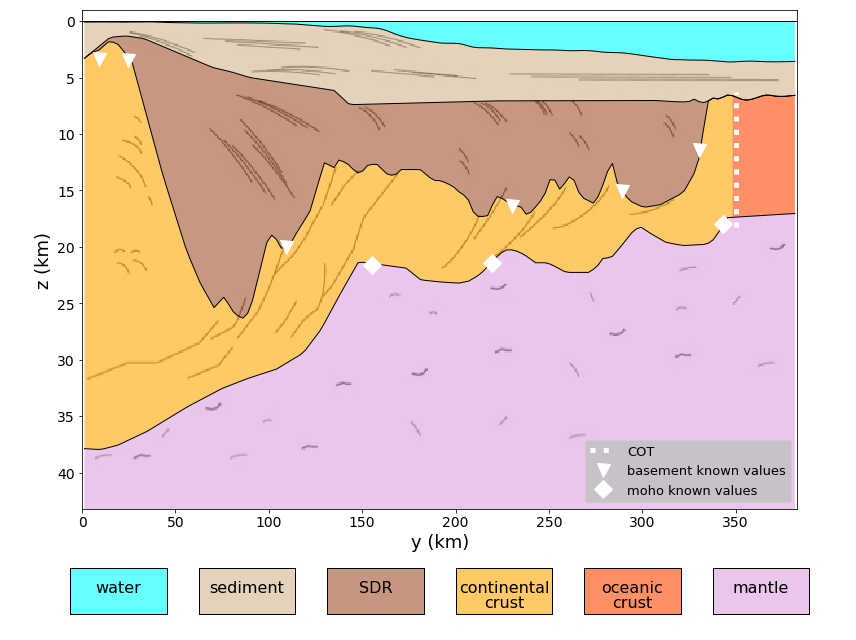

In [84]:
%matplotlib inline
plt.close('all')
fig = plt.figure(figsize=(12,9))

import matplotlib.gridspec as gridspec
heights = [10, 1]
gs = gridspec.GridSpec(2, 1, height_ratios=heights)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.axhline(y=0.0, xmin=ymin, xmax=ymax, color='k', linestyle='-', linewidth=1)
ax1.plot(yc, tw, '-k', linewidth=1)
ax1.plot(yc, toi, '-k', linewidth=1)
ax1.plot(yc, basement, '-k', linewidth=1)
ax1.plot(yc, S, '-k', linewidth=1)
ax1.axvline(x=COT, ymin=ybottom, ymax=ytop, linestyle=':', color='w', linewidth=5, label='COT')
ax1.plot(base_known[:,0], base_known[:,1], 'vw', markersize=13.0, label='basement known values')
ax1.plot(moho_known[:,0], moho_known[:,1], 'Dw', markersize=13.0, label='moho known values')
ax1.fill_between(yc, 0.0, tw, facecolor='aqua', alpha=0.6)
ax1.fill_between(yc, tw, toi, facecolor='tan', alpha=0.6)
ax1.fill_between(yc, toi, base, facecolor='sienna', alpha=0.6)
ax1.fill_between(yc, base, S, where=aux2, facecolor='orange', alpha=0.6)
ax1.fill_between(yc, base, S, where=aux3, facecolor='orangered', alpha=0.6)
ax1.fill_between(yc, S, ymax, facecolor='plum', alpha=0.6)
ax1.imshow(img, extent=extent, aspect=calculate_aspect(shape,extent))
ax1.set_ylim(S0+dS0, zmin)
ax1.set_xlim(ymin, ymax)
ax1.set_xlabel('y (km)', fontsize=18)
ax1.set_ylabel('z (km)', fontsize=18)
ax1.set_xticklabels(['%g'% (0.001*l) for l in ax1.get_xticks()], fontsize=14)
ax1.set_yticklabels(['%g'% (0.001*l) for l in ax1.get_yticks()], fontsize=14)
ax1.legend(loc='lower right', fontsize=13, facecolor='silver')    

X, Y = fig.get_dpi()*fig.get_size_inches()
ax2.axis('off')

layers_list1 = ['water', 'sediment', 'SDR', 'continental', 'oceanic', 'mantle']
layers_list2 = ['', '', '', 'crust', 'crust', '']
colors_list = ['aqua', 'tan', 'sienna', 'orange', 'orangered', 'plum']
ncols = len(colors_list)
nrows = 1
h = Y / nrows
w = X / (ncols + 1)

i=ncols-1
for color, layers1, layers2 in zip(colors_list, layers_list1, layers_list2):
    col = i // nrows
    row = i % nrows
    x = X - (col*w) - w
    
    yi_line = Y
    yf_line = Y - Y*0.15
    yi_text1 = Y - Y*0.04
    yi_text2 = Y - Y*0.09
    
    i-=1
    poly = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yi_line, yi_line, yf_line, yf_line]]).T)
    tmpx = [x for x in poly.x]
    tmpx.append(poly.x[0])
    tmpy = [y for y in poly.y]
    tmpy.append(poly.y[0])
    ax2.plot(tmpx, tmpy, linestyle='-', color='k', linewidth=1)
    ax2.fill(tmpx, tmpy, color=color, alpha=0.6)
    ax2.text(x+w*0.375, yi_text1, layers1, fontsize=(w*0.13), horizontalalignment='center', verticalalignment='top')
    ax2.text(x+w*0.375, yi_text2, layers2, fontsize=(w*0.13), horizontalalignment='center', verticalalignment='top')

plt.tight_layout()    
#mpl.savefig('../data/fig/pelotas-interpretation-colors-plus-faults.png', dpi='figure', bbox_inches='tight')
plt.show()